In [1]:
# Standard library imports
import multiprocessing
import os

# Third-party imports
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from hyperopt import hp

# Local imports
from mlarena import ML_PIPELINE, PreProcessor

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)


# mlareana Advanced Usage

1. PreProcessing strategy analysis
2. Custom configure algorithms and preprocessing strategy
3. Bayesian Hyperparameter tuning
4. Threshold analysis for classification models

# 1. PreProcessing Strategy Analysis

In [2]:
# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(100, 10, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features with low cardinality
    'education': np.random.choice(['High School', 'Bachelor', 'Master or above'], n_samples),
    'occupation': np.random.choice(['Engineer'], n_samples), #only one value
    
    # Categorical features with higher cardinality
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*80 + ['D']*30 + ['E']*20 + ['F']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

## Filter Feature Selection

Run filter feature selection based on 
1. missing threshold
2. mutual information threshold
3. feature with only one single value will also be excluded

In [3]:
fitler_fs = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  mi_threshold = 0.05)

Filter Feature Selection Summary:
Total features analyzed: 7

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Low mutual information (<0.05): 3 columns
   Columns: age, tenure, occupation

Recommended drops: (3 columns in total)


In [4]:
# detailed results available as a dataframe
fitler_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
0,city,0.0200,5,0.00625,object,0.016899,1.000000,False,False,False
1,product,0.0000,6,0.00750,object,0.011228,0.664413,False,False,False
2,income,0.0000,800,1.00000,float64,0.001354,0.080128,False,False,False
3,education,0.0275,3,0.00375,object,0.000904,0.053503,False,False,False
4,age,0.0475,762,0.95250,float64,0.000000,0.000000,False,False,True
5,tenure,0.0000,13,0.01625,int32,0.000000,0.000000,False,False,True
6,occupation,0.0000,1,0.00125,object,0.000000,0.000000,False,True,True


In [5]:
selected_cols = fitler_fs['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income, education


## Recommend encoding candidates

The `identify_encoding_candidates` method recommend encoding based on:

1. High cardinality threshold
2. Rare category
3. User preference

In [6]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train[selected_cols], 
                                                                 high_cardinality_threshold=5)

-------------------------
Column `city` Analysis:
Recommend target encoding with higher smoothing due to moderate cardinality and rare category

column `city` details:
• Missing rate: 2.0%
• Unique values: 5
• Minimum category size: 24
• Rare categories: 2
-------------------------
Column `product` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `product` details:
• Missing rate: 0.0%
• Unique values: 6
• Minimum category size: 14
• Rare categories: 3
-------------------------
Column `education` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `education` details:
• Missing rate: 2.8%
• Unique values: 3
• Minimum category size: 247
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 3
• One-hot encoding cols: 0


In [7]:
# access the detailed analysis in dataframe form if preferred
encoding_recommendations['analysis']

,column,missing_rate,unique_values,min_category_size,rare_categories,encoding_note
0,city,0.0200,5,24,2,"Has 2 rare categories, careful for sparse feat..."
1,product,0.0000,6,14,3,Has 3 rare categories. Recommend higher smooth...
2,education,0.0275,3,247,0,Either encoding will do due to moderate cardin...


In [8]:
target_encode_cols = encoding_recommendations['target_encode_cols']
preprocessor = PreProcessor(
    target_encode_cols=target_encode_cols,
    target_encode_smooth='auto'
)
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_cols],y_train)
X_test_preprocessed =  preprocessor.transform(X_test[selected_cols])

## Compare Smoothing Strategies

Once the target encoding columns have been selected, the next decision we need to make is about the best smoothing strategies, which can be used to balance between the raw category means and the global mean to avoid overfitting. Two main smoothing strategies are available:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

As shown above, different smoothing strategies returns diffent result for a column of interests. The `plot_target_encoding_comparison` method visualizes how different smoothing parameters affect the encoded values. This is especially critical for categorical features with rare categories where overfitting is a bigger concern. Pls see below the visualization of `city`, where rare categories exist, and `education` with sufficiant sample sizes for each category. Smoothing parameters make a big difference for `city`, and in particular for the rare cagtegory Seattle whose train mean is much lower than the global mean. 

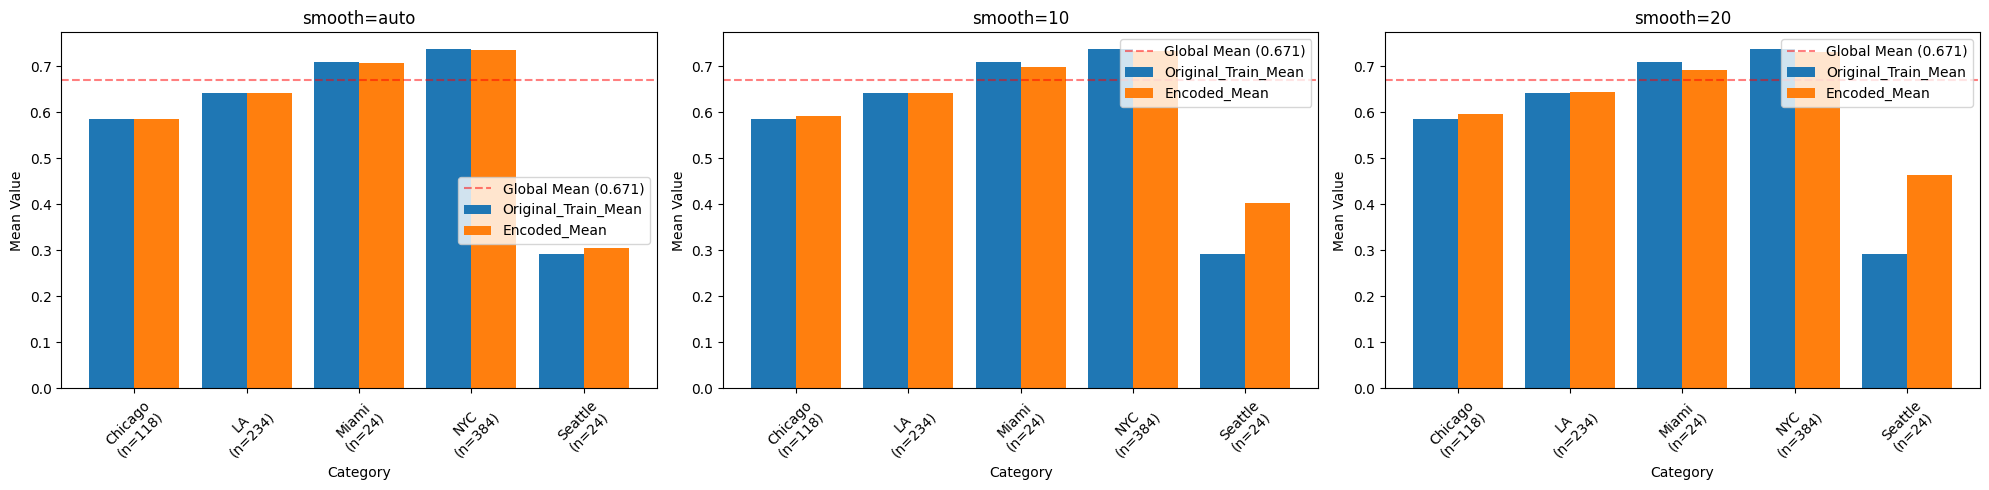

In [9]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

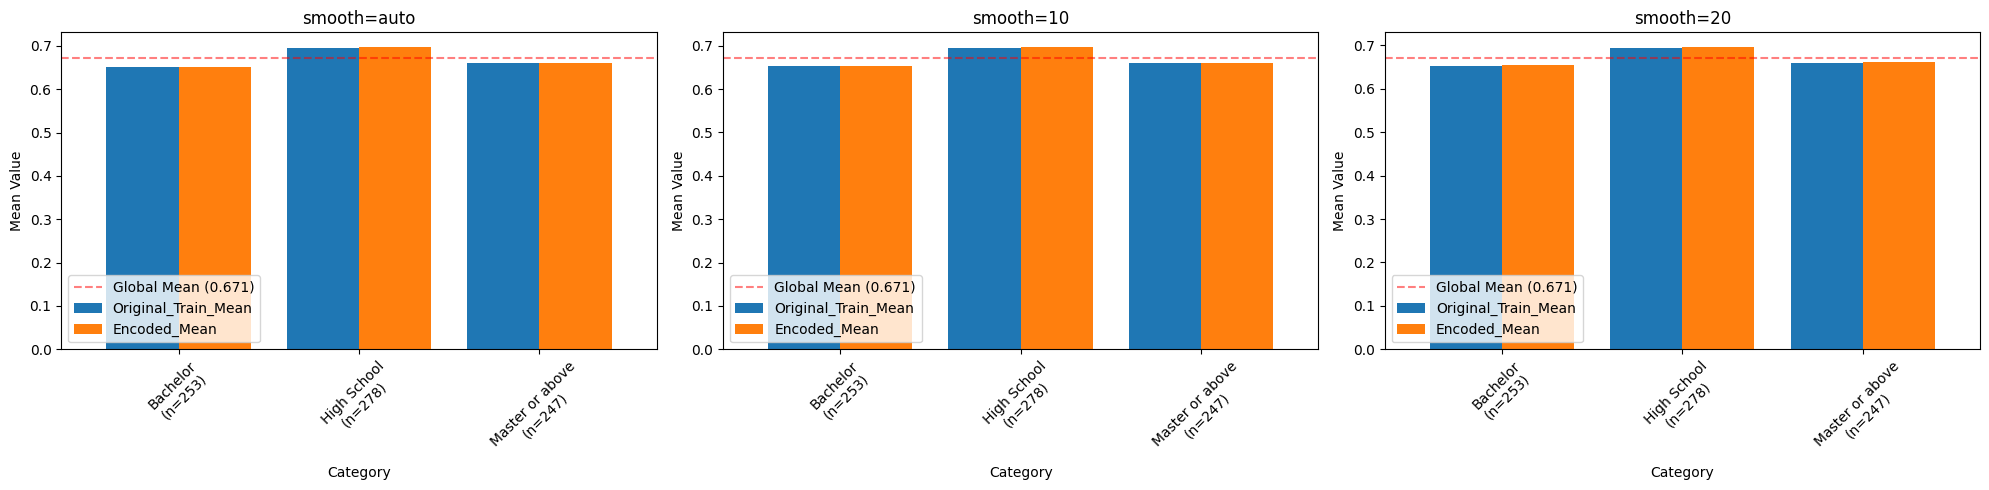

In [10]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'education',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

# 2. Custom Configure Algorithms and Preprocessing Strategy

In [11]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train)

-------------------------
Column `sex` Analysis:
Recommend one-hot encoding as the number of unique value is less or equal to 2

column `sex` details:
• Missing rate: 0.0%
• Unique values: 2
• Minimum category size: 278
• Rare categories: 0
-------------------------
Column `embarked` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `embarked` details:
• Missing rate: 0.1%
• Unique values: 3
• Minimum category size: 72
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 1


In [13]:
# custom configure the algorithm and preprocessor
lgb_params = {
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "scale_pos_weight": 1.9,
    "verbose": -1
}
ml_pipeline = ML_PIPELINE(
    model=lgb.LGBMClassifier(**lgb_params),
    preprocessor=PreProcessor(
        num_impute_strategy="mean",  # default "median"
        target_encode_cols=encoding_recommendations["target_encode_cols"],
    ),
)
ml_pipeline.fit(X_train, y_train)

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.779
F1:        0.741
Precision: 0.783
Recall:    0.703
Pos Rate:  0.405

AUC (threshold independent):
AUC:   0.854


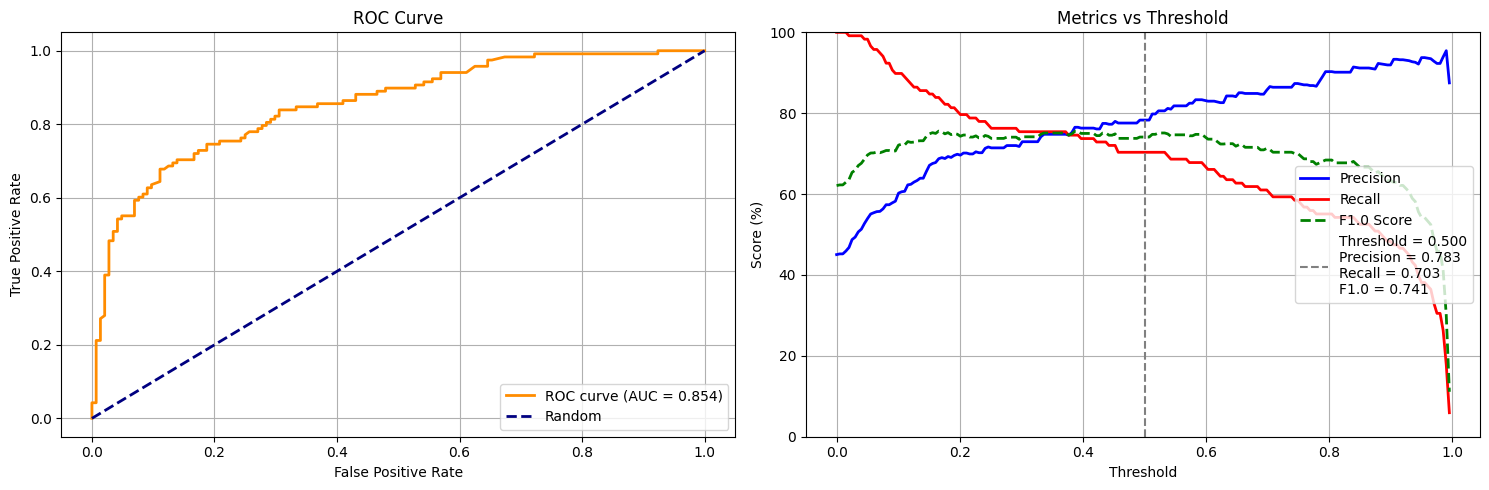

In [14]:
results = ml_pipeline.evaluate(X_test, y_test)

# 3. Bayesian Hyperparameter Tuning

Below is a summary of three main approaches for hyperparameter tuning. 


| Approach        | Search Strategy                           | Efficiency  | Strengths                                           | Weaknesses                                       | When to Use |
|---------------|----------------------------------|------------|------------------------------------------------|------------------------------------------------|--------------|
| **Grid Search** | Exhaustive search over a predefined grid | Low         | - Guarantees finding the best combination (if small search space)  | - Computationally expensive, scales poorly with dimensionality | Small, well-defined search spaces |
| **Random Search** | Samples hyperparameters randomly | Medium      | - More efficient than grid search, explores more diverse values | - Does not leverage past results for better sampling | Large search spaces, unknown parameter importance |
| **Bayesian Optimization (e.g., TPE in Hyperopt)** | Builds a probabilistic model to guide search | High        | - Learns from past evaluations, focuses on promising areas | - More complex to implement, can be slower in early iterations | Optimize search routes for expensive evaluations to achieve the best result effectively |


<br>



The advantage of the Bayesian method over grid and random search is that it intelligently guides the search for optimal hyperparameters by leveraging past evaluations, making it more efficient and effective, especially in large or complex search spaces. While the approach is admittedly more complex, `mlarena` offers a `tune` method that makes it more approachable and easier to implement. Its features include 

- Iterative tuning using Tree-structured Parzen Estimators (TPE) via hyperopt
- Implements k-fold cross-validation for robust evaluation
- Early stopping option to avoid overfitting and wasted computation
- Supports custom preprocessing pipelines
- Works well with any ML algorithm that follows sklearn API convensions
- Comprehensive reports with common metrics and plots
- Parallel coordinates plot for diagnosis of the search space


In [15]:
# Define the hyperparameter search space
lgb_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'num_leaves': hp.choice('num_leaves', range(20, 100)),  
    'max_depth': hp.choice('max_depth', range(5, 15)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 0.9)
}

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

 58%|█████▊    | 292/500 [04:19<03:04,  1.13trial/s, best loss: -0.8459665089094146]
Best CV AUC: 0.853(0.036)

Performance on holdout validation set:
Classification Metrics Report

Evaluation Parameters:
Threshold: 0.348
Beta:      1.000

Metrics:
Accuracy:  0.786
F1:        0.754
Precision: 0.775
Recall:    0.734
Pos Rate:  0.424

AUC (threshold independent):
AUC:   0.850


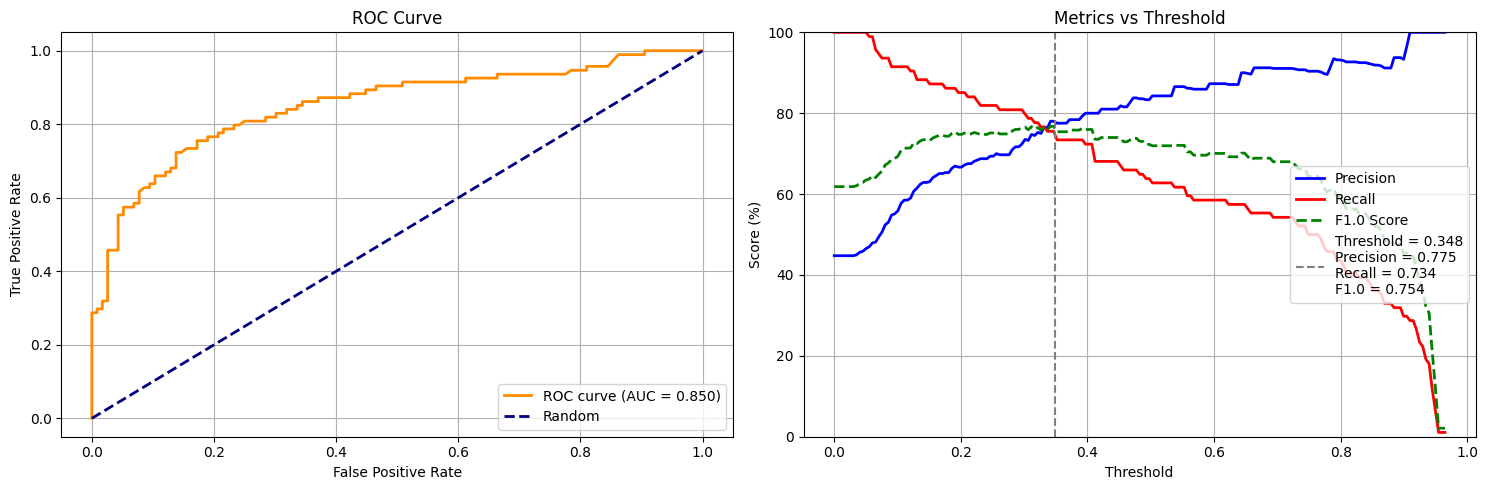


Hyperparameter Tuning Results

Best parameters found:
colsample_bytree: 0.8464654546207054
learning_rate: 0.010014646946714218
max_depth: 11
n_estimators: 300
num_leaves: 82
subsample: 0.7734778304516453


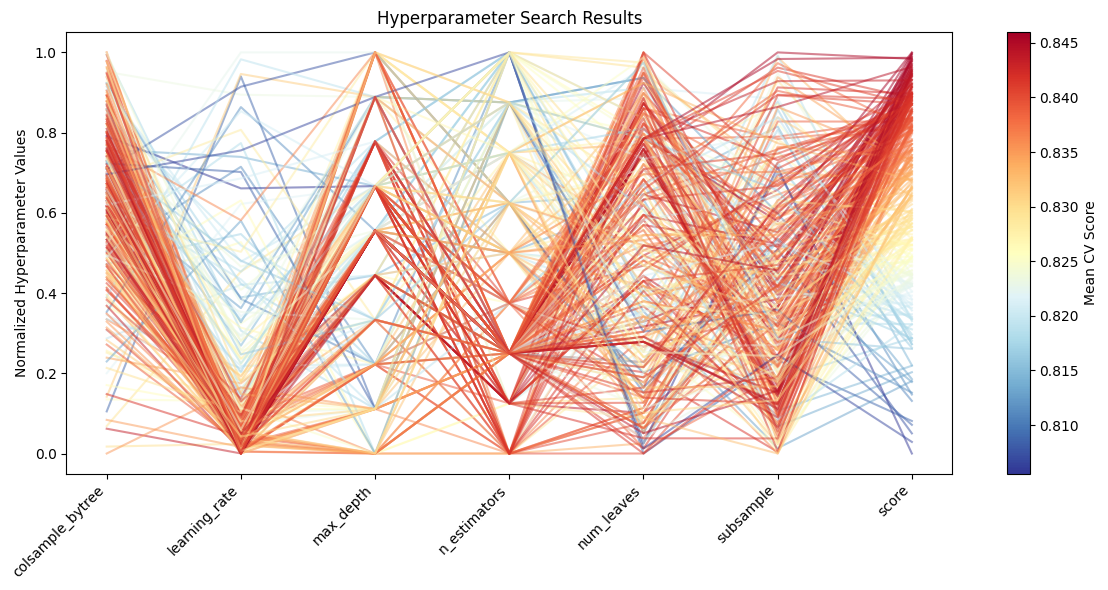

In [16]:
best_lgb = ML_PIPELINE.tune(X_train_full, y_train_full, 
                               algorithm=lgb.LGBMClassifier, 
                               preprocessor = PreProcessor(
                                   target_encode_cols=encoding_recommendations["target_encode_cols"],
                                   ),
                               space = lgb_space, 
                               beta = 1,
                               max_evals = 500,
                               early_stopping_rounds = 100,
                               verbose = -1,
                               cv = 5,
                               cv_variance_penalty=0.2)

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.348
Beta:      1.000

Metrics:
Accuracy:  0.771
F1:        0.732
Precision: 0.774
Recall:    0.695
Pos Rate:  0.405

AUC (threshold independent):
AUC:   0.851


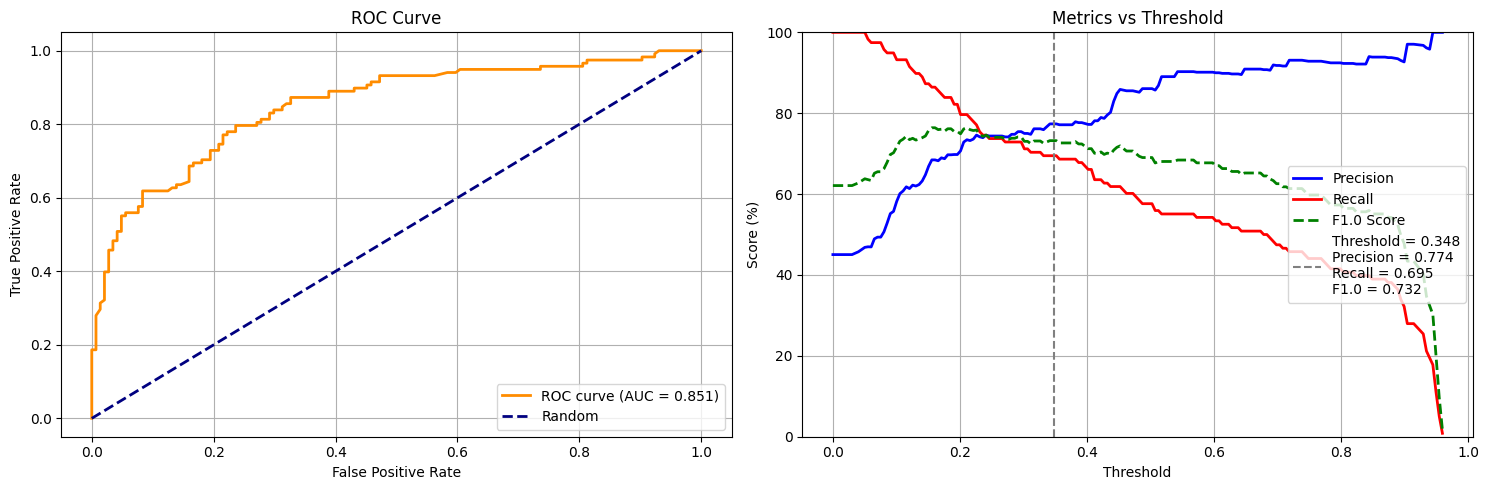

In [19]:
# extract the best model, evaluate with new data and understand its reasoning
best_pipeline = best_lgb['best_pipeline']
beta = best_lgb['beta']
optimal_threshold = best_lgb['optimal_threshold']
metrics = best_pipeline.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)